## Add Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import warnings 
warnings.filterwarnings('ignore')

## Read In Data

In [ ]:
# pokedex
df1 = pd.read_csv("data/pokedex.csv", index_col=0)
df1["image_address"] = df1["image"]
df1 = df1.drop(columns = "image")

# pokedex4
df2 = pd.read_csv("data/pokedex2.csv", index_col=0)

# concat dataframes
df = pd.concat([df1, df2])
df = df.drop(columns = "type2")
df

,dex_no,name,type1,image_name,image_address
0,1.0,Bulbasaur,Grass,pokedex_bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2.0,Ivysaur,Grass,pokedex_ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3.0,Venusaur,Grass,pokedex_venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4.0,Charmander,Fire,pokedex_charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5.0,Charmeleon,Fire,pokedex_charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...
1150,NaN,Iron_Valiant,Fairy,pokedex2_Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...
1151,NaN,Koraidon,Fighting,pokedex2_Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...
1152,NaN,Miraidon,Electric,pokedex2_Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...
1153,NaN,Walking_Wake,Water,pokedex2_Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...


In [ ]:
# make new dataframe out of all the images listed in the images folder
df_imagesonly = pd.DataFrame(os.listdir("data/images"))
df_imagesonly.columns = ["image_name"]
df_imagesonly["name"] = df_imagesonly["image_name"]
df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")
df_imagesonly["name"] = df_imagesonly["name"].str.capitalize()
df_imagesonly["name"] = df_imagesonly["name"].str.split("_").apply(lambda x: x[1])
df_imagesonly["name"] = df_imagesonly["name"].str.title()

In [ ]:
# create new dataframe for just names and types
names_and_types = df[["name", "type1"]]

# combine with df_imagesonly
images_types = df_imagesonly.merge(names_and_types)
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19664,pokedex2_Ninetales-Alola.png,Ninetales-Alola,Ice
19665,pokedex_burmy.jpg,Burmy,Bug
19666,pokedex2_Raichu-Alola.png,Raichu-Alola,Electric
19667,pokedex2_Eiscue-Noice.png,Eiscue-Noice,Ice


## EDA

We have about 2000 images from our scraped collection and almost 8000 from our other datasets. The majority of the images are for Generation 1 and the original 150 Pokémon, thanks to the additional datasets. The rest include two images each for Generations 1-9, which includes over 1000 Pokémon. This dataset includes regional variant Pokémon for Alola and Galar.

There is a pretty large range in the amount of images are in the dataset. From over 500 to only 1. Let's look at the most common Pokemon.

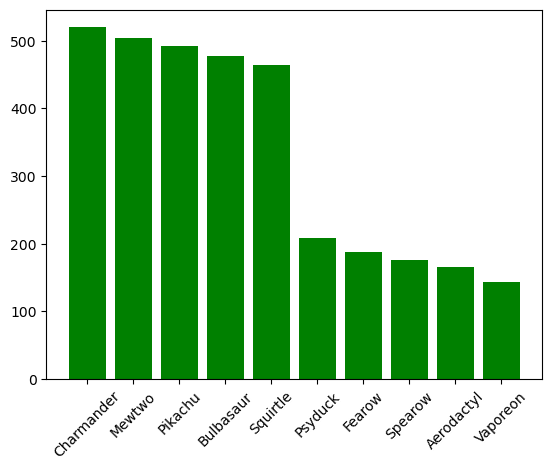

In [ ]:
top_pokemon = dict(images_types["name"].value_counts().head(10))
plt.bar(top_pokemon.keys(), top_pokemon.values(), color='g')
plt.xticks(rotation = 45);

In [ ]:
images_types["name"].value_counts().tail(10)

Basculin-Red       1
Goodra-Hisui       1
Aegislash          1
Indeedee           1
Rotom-Fan          1
Zacian-Hero        1
Cherrim-Sunny      1
Morpeko            1
Kyurem-White       1
Sandshrew-Alola    1
Name: name, dtype: int64

We have more photos of Charmander, Mewtwo, Pikachu, Bulbasaur, and Squirtle than the rest and some have only one image each.

The second thing we'll want to do is understand which types are represented in amongst our images and how many of each kind are there.

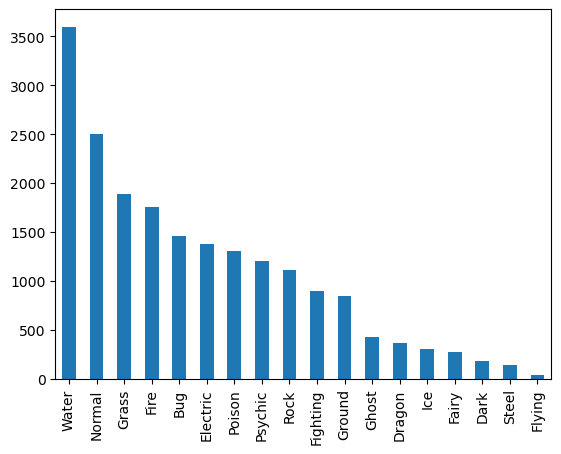

In [ ]:
images_types.type1.value_counts().plot(kind='bar');

The vast majority of the Pokémon seem to be Water types, followed by Normal and Grass. This might skew our data, though intuitively it's more likely that the model misclassifies Bug and Grass for each other as they often are the same shape and color.

Ghost, Dragon, Ice, Fairy, Dark, Steel, and Flying are the least populated types. But that could be because they're often the secondary types for Pokémon, which we're not including in modelling to make it simpler. We'll focus on the 10 most populated types.

In [ ]:
# cleaning
# remove rows that do not contain main types
main_types = ["Water", "Normal", "Grass", "Pyschic", "Bug", "Fire", "Poison", "Ground", "Fighting", "Rock"]
images_types = images_types[images_types['type1'].isin(main_types)]
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19656,pokedex2_Typhlosion-Hisui.png,Typhlosion-Hisui,Fire
19657,pokedex_urshifu.jpg,Urshifu,Fighting
19658,pokedex_shellos.jpg,Shellos,Water
19659,pokedex2_Slowbro-Galar.png,Slowbro-Galar,Poison


## Split Folders for Train-Test and By Class

Time to get modelling. We'll start by sorting images into train and test, making folders for both, creating classifier labels, and then moving the images into their proper type classifier folder within both the trian and test folders.

In [ ]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.2)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/val/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df_tts = pd.concat(pdList)
df_tts = df_tts.drop_duplicates('image_name')
df_tts

Copying files: 10131 files [00:04, 2384.72 files/s]


,image_name,name,type1,split
4,dataset_Dodrio26.jpg,Dodrio,Normal,train
6,dataset_Dodrio32.jpg,Dodrio,Normal,train
8,dataset_Dodrio24.jpg,Dodrio,Normal,train
10,dataset_Dodrio30.jpg,Dodrio,Normal,train
12,dataset_Dodrio18.jpg,Dodrio,Normal,train
...,...,...,...,...
19645,pokedex2_Shellos-East.png,Shellos-East,Water,test
19649,pokedex2_Burmy-Sandy.png,Burmy-Sandy,Bug,test
19650,pokedex2_Lycanroc-Dusk.png,Lycanroc-Dusk,Rock,test
19651,pokedex2_Burmy-Trash.png,Burmy-Trash,Bug,test


In [ ]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/val/images'

for index, row in df_tts.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label))

Error: Destination path 'train_test_folders/train/images/Normal/dataset_Dodrio26.jpg' already exists

# Modelling

First we'll create the generators we'll run our CNN models on. Because Pokémon images are pretty simple in design with black outlines and 2-3 colors, a smaller image size will make our models run better and faster. We'll aslo includ the "rgb" color mode.

In [ ]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/val/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (32, 32), color_mode = "rgb", 
                                                    batch_size = 32, class_mode = "categorical")

test_generator = data_gen.flow_from_directory(test_path, target_size = (32, 32), color_mode = "rgb", 
                                                    batch_size = 32, class_mode = "categorical")

## Model 1

For Model 1, we're going to use a simple convolutional model set up with a kernel size of (2,2). We'll have three layers between our input and output.

In [ ]:
# set regulator, loss function, and Adam optimizer
reg = l2(3e-3)
cce = tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

In [ ]:
# build model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(9, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_1 = model.fit(train_generator, verbose = 1, validation_data = test_generator, epochs=100)

Not bad for our first model! Nearly 95% accuracy for train and almost 60% for test. There's definitely some overfit happening, but for now we're getting higher than our modeless baseline which would be 24% (367/1534 for the majority class water).

Let's plot it and see what these epochs look like in terms of loss and accuracy.

In [ ]:
# plot loss
plt.plot(model_1.history["loss"], label = "train loss");
plt.plot(model_1.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
# plot accuracy
plt.plot(model_1.history["accuracy"], label = "train accuracy");
plt.plot(model_1.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

It'll help us to know what's getting mislabeled. Let's do a confusion matrix using the types we've inputted previously.

In [ ]:
# new labels
types = ["Water", "Rock", "Poison", "Normal", "Ground", "Grass", "Fire", "Fighting", "Bug"]

# get predicted values
Y_pred = model.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Base Model Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

It looks like Bug and Grass are often mistaken for each other, which makes sense. Usually these types overlap considerably with some Pokémon having both types. They're also often both green-colored.

In fact, our Bug and Grass types overall seem to be having the most issues. The model is mistaking too many other types for these ones.

## Model 2

While train accuracy seems to be going up with each epoch, it looks like test accuracy is holding steady around 53-55% despite the number of epochs. 

We need to solve for overfitting. To do this we can increase regularization, add more convolutional layers, decrease learning rate, and/or change the optimization algorithm from adam to something like SGD.

To begin out iterative process, we'll start by increasing regularization with Dropout and early stopping.

In [ ]:
# set Early Stopping for callbacks
es = EarlyStopping(monitor = "val_accuracy", mode = "min", verbose = 1, patience = 30)

In [ ]:
# build model
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(Flatten())
model2.add(Dense(32, activation='relu', kernel_regularizer = reg))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu', kernel_regularizer = reg))
model2.add(Dense(9, activation='softmax', kernel_regularizer = reg))
model2.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_2 = model2.fit(train_generator, verbose = 1, validation_data = test_generator, epochs = 100, callbacks=[es])

In [ ]:
# plot loss
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
# plot accuracy
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

While overfit no longer seems to be an issue, our accuracy is much lower than before. Let's use a confusion matrix to see what the model is getting wrong.

In [ ]:
# get predicted values
Y_pred = model2.predict(test_generator, 1534// 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 2 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

The type mislabeling is out of control! Everything is now being called a Bug, Grass, Normal, or Poison type despite what it looks like. Not good. Let's go back to Model 1 and try something else.

## Model 3

For Model 3, we're going to use Model 1 again but swap Adam for SGD.

In [ ]:
# build model
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(Flatten())
model3.add(Dense(32, activation='relu', kernel_regularizer = reg))
model3.add(Dense(16, activation='relu', kernel_regularizer = reg))
model3.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model3.compile(optimizer='sgd', loss=cce,  metrics=['accuracy'])
model_3 = model3.fit(train_generator, verbose=1, validation_data = test_generator, epochs=50, callbacks=[es])

In [ ]:
# plot loss
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
# plot accuracy
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

Overfitting seems to be relatively solved at this point, though accuracy on the whole is down again.

In [ ]:
# get predicted values
Y_pred = model3.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 3 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

We're still not seeing an overal trend towards accurate predictions.

## Model 4

Accuracy on the whole was best in the last model, using the sgd optimizer. Let's continue that with the next one but increase the amount of layers.

In [ ]:
# build model
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(Flatten())
model4.add(Dense(32, activation='relu', kernel_regularizer = reg))
model4.add(Dense(32, activation='relu', kernel_regularizer = reg))
model4.add(Dense(32, activation='relu', kernel_regularizer = reg))
model4.add(Dense(16, activation='relu', kernel_regularizer = reg))
model4.add(Dense(16, activation='relu', kernel_regularizer = reg))
model4.add(Dense(16, activation='relu', kernel_regularizer = reg))
model4.add(Dense(8, activation='relu', kernel_regularizer = reg))
model4.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model4.compile(optimizer='sgd', loss=cce,  metrics=['accuracy'])

model_4 = model4.fit(train_generator, verbose=1, validation_data = test_generator, epochs=100, callbacks = [es])

In [ ]:
# plot loss
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
# plot accuracy
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

The test accuracy seems to be stalling out around 40%.

In [ ]:
# get predicted values
Y_pred = model4.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 4 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

Again, nothing is being labled as Water, Rock, Ground, or Fighting. Grass and Bug labeling is mostly wrong.

Adding more layers didn't seem to solve much. The last thing we can try is changing the learning rate.

## Model 5

More layers!

In [ ]:
# build model
opt = SGD(lr=0.01, momentum=0.9)
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(Flatten())
model5.add(Dense(32, activation='relu', kernel_regularizer = reg))
model5.add(Dense(16, activation='relu', kernel_regularizer = reg))
model5.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model5.compile(optimizer = opt, loss=cce,  metrics=['accuracy'])
model_5 = model5.fit(train_generator, verbose=1, validation_data = test_generator, epochs=50, callbacks=[es])

In [ ]:
# plot loss
plt.plot(model_5.history["loss"], label = "train loss");
plt.plot(model_5.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
# plot accuracy
plt.plot(model_5.history["accuracy"], label = "train accuracy");
plt.plot(model_5.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

In [ ]:
# get predicted values
Y_pred = model5.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 5 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

It seems like with more layers, the model is defaulting to labeling almost everything as Bug, Poison, or Normal types.

Of the five models we tried, Model 3 is the best with sgd optimizer.